#  <center> Problem Set 4 <center>
<center> Spring 2021 <center>
<center> 3.100/3.322, 10.402/10.602, 20.301/20.401 <center>
<center> Due:10 pm ET on Thursday, Apr 22, 2021 <center>

## Part 2 Graph Convolutional Nets 

### 1.1 Install and try out RDkit

In [2]:
# First, Request a GPU by going to Edit/Notebook Settings/Hardward Accelerator

In [3]:
# This is a hack to install rdkit without needing to install conda which might take minutes 
# if you have anaconda installed, you can install rdkit from anaconda 
url = 'https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'
!curl -L $url | tar xj lib
!mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.7/dist-packages/

x86 = '/usr/lib/x86_64-linux-gnu'
!mv lib/*.so.* $x86/
!ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3753    0  3753    0     0   8627      0 --:--:-- --:--:-- --:--:--  8607
100 20.2M  100 20.2M    0     0  5382k      0  0:00:03  0:00:03 --:--:-- 7370k


In [3]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import sys
import torch 
from tqdm import tqdm
import itertools

from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*') # turn off RDKit warning message 

In [3]:
# Optional: mount your google drive to save model and files 

from google.colab import drive
drive.mount('/content/drive')
mydrive = '/content/drive/MyDrive'

In [4]:
### example 
# make a mol object 
dopamine_mol = Chem.MolFromSmiles("C1=CC(=C(C=C1CCN)O)O") # Dopamine 
caffeine_mol = Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C") # Caffeine 

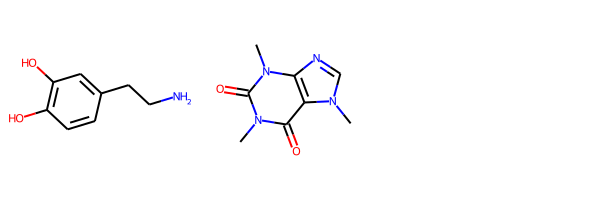

In [5]:
# Arrange molecules in a grid image
Draw.MolsToGridImage([dopamine_mol, caffeine_mol])

### 1.2 Construct Molecular Graph Datasets

In [ ]:
! wget https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps4/data/qm9.csv

In [6]:
# implement SMILES to graph function  
def smiles2graph(smiles):
    '''
    Transfrom smiles into a list nodes (atomic number)
    
    Args: 
        smiles (str): SMILES strings
    
    return: 
        z(np.array), A (np.array): list of atomic numbers, adjancency matrix 
    '''
    
    mol = Chem.MolFromSmiles( smiles ) # no hydrogen 
    z = np.array( [atom.GetAtomicNum() for atom in mol.GetAtoms()] )
    A = np.stack(Chem.GetAdjacencyMatrix(mol))
    
    return z, A

In [10]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self,
                 AtomicNumber_list, 
                 Edge_list, 
                 Natom_list, 
                 y_list):
        
        '''
        GraphDataset object
        
        Args: 
            z_list (list of torch.LongTensor)
            a_list (list of torch.LongTensor)
            N_list (list of int)
            y_list (list of torch.FloatTensor)

        '''
        self.AtomicNum_list = AtomicNum_list # atomic number
        self.Edge_list = Edge_list # edge list 
        self.Natom_list = Natom_list # Number of atoms 
        self.y_list = y_list # properties to predict 

    def __len__(self):
        return len(self.Natom_list)

    def __getitem__(self, idx):
        
        AtomicNum = torch.LongTensor(self.AtomicNum_list[idx])
        Edge = torch.LongTensor(self.Edge_list[idx])
        Natom = self.Natom_list[idx]
        y = torch.Tensor(self.y_list[idx])
        
        return AtomicNum, Edge, Natom, y

In [13]:
def collate_graphs(batch):
    '''Batch multiple graphs into one batched graph
    
    Args:
    
        batch (tuple): tuples of AtomicNum, Edge, Natom and y obtained from GraphDataset.__getitem__() 
        
    Return 
        (tuple): Batched AtomicNum, Edge, Natom, y
    
    '''
    
    AtomicNum_batch = []
    Edge_batch = []
    Natom_batch = []
    y_batch = []

    cumulative_atoms = np.cumsum([0] + [b[2] for b in batch])[:-1]
    
    for i in range(len(batch)):
        z, a, N, y = batch[i]
        index_shift = cumulative_atoms[i]
        a = a + index_shift
        AtomicNum_batch.append(z) 
        Edge_batch.append(a)
        Natom_batch.append(N)
        y_batch.append(y)
        
    AtomicNum_batch = torch.cat(AtomicNum_batch)
    Edge_batch = torch.cat(Edge_batch, dim=1)
    Natom_batch = Natom_batch
    y_batch = torch.cat(y_batch)
    
    return AtomicNum_batch, Edge_batch, Natom_batch, y_batch 

In [20]:
# Example usage of collate_graph

# define graph 1 
AtomicNum1 = torch.LongTensor([6, 6, 7])
Edge1 = torch.LongTensor([[0, 2, 2, 1], 
                       [2, 0, 1, 2]])
Natom1 = 3
y1 =  torch.Tensor([74.18])
# define graph 2 
AtomicNum2 = torch.LongTensor([6, 6, 8])
Edge2 = torch.LongTensor([[0, 2, 2, 1], 
                       [2, 0, 1, 2]])
Natom2 = 3
y2 = torch.Tensor([64.32])

graph1 = (AtomicNum1, Edge1, Natom1, y1)
graph2 = (AtomicNum2, Edge2, Natom2, y2)

collate_graphs((graph1, graph2))  

(tensor([6, 6, 7, 6, 6, 8]),
 tensor([[0, 2, 2, 1, 3, 5, 5, 4],
         [2, 0, 1, 2, 5, 3, 4, 5]]),
 [3, 3],
 tensor([74.1800, 64.3200]))

Make lists of data for molecular graphs

In [ ]:
import torch
from sklearn.utils import shuffle

df = pd.read_csv("qm9.csv")
df = shuffle(df).reset_index()

################ Code #################

AtomicNum_list = []
Edge_list = []
y_list = []
Natom_list = []




Make train, valdiation, test datasets and dataloaders

In [131]:
################ Code #################
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


### 1.4 Implement a Graph Convolution Model

In [132]:
from itertools import repeat
def scatter_add(src, index, dim_size, dim=-1, fill_value=0):
    
    '''
    Sums all values from the src tensor into out at the indices specified in the index 
    tensor along a given axis dim. 
    '''
    
    index_size = list(repeat(1, src.dim()))
    index_size[dim] = src.size(dim)
    index = index.view(index_size).expand_as(src)
    
    dim = range(src.dim())[dim]
    out_size = list(src.size())
    out_size[dim] = dim_size

    out = src.new_full(out_size, fill_value)

    return out.scatter_add_(dim, index, src)

#### Example usage for scatter_add() and torch.split() 

In [149]:
# scatter_add() example usage 
tensor = torch.ones(5, 2) # source array 
index = torch.LongTensor([0, 0, 2, 2, 1]) # index to be summed 
print(scatter_add(tensor, index, dim=0, dim_size=3))

tensor([[2., 2.],
        [1., 1.],
        [2., 2.]])


In [150]:
# torch.split() example usage 
splits_idx = [2, 3] # list of integers 
print( torch.split(tensor, splits_idx) ) 

# you have two tensors with size (2,2) and (3,2) respectively 
for split in torch.split(tensor, splits_idx):
    print(split.shape)

(tensor([[1., 1.],
        [1., 1.]]), tensor([[1., 1.],
        [1., 1.],
        [1., 1.]]))
torch.Size([2, 2])
torch.Size([3, 2])


In [151]:
# And you can sum the spllited array separately and stack them together 
print( torch.stack([split.sum(0) for split in torch.split(tensor, splits_idx)], dim=0) )


tensor([[2., 2.],
        [3., 3.]])


In [171]:
from torch import nn
from torch.nn import ModuleDict

class GNN(torch.nn.Module):
    '''
        A GNN model 
    '''
    def __init__(self, n_convs=3, n_embed=64):
        super(GNN, self).__init__()
        
        self.atom_embed = nn.Embedding(100, n_embed)
        # Declare MLPs in a ModuleList
        self.convolutions = nn.ModuleList(
            [ 
                ModuleDict({
                    'update_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                nn.ReLU(), 
                                                nn.Linear(n_embed, n_embed)),
                    'message_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                 nn.ReLU(), 
                                                 nn.Linear(n_embed, n_embed)) 
                })
                for _ in range(n_convs)
            ]
            )
        # Declare readout layers
        self.readout = nn.Sequential(nn.Linear(n_embed, n_embed), nn.ReLU(), nn.Linear(n_embed, 1))
        
    def forward(self, AtomicNum, Edge, Natom):
        ################ Code #################
        
        # Parametrize embedding 
        h = self.atom_embed(AtomicNum) #eqn. 1
        
        for conv in self.convolutions:
        
    
        
        ################ Code #################
        return output

### 1.5 Graph Convolution Operation preserves Permutation Invariances

In [1]:
def permute_graph(z, a, perm):
    '''
        permute the order of nodes in a molecular graph 
        
        Args: 
            z(np.array): atomic number array
            a(np.array): edge index pairs 
            
        Return: 
            (np.array, np.array): permuted atomic number, and edge list 
    '''
    
    z = np.array(z)
    perm = np.array(perm)
    assert len(perm) == len(z)
    
    z_perm = z[perm]
    a_perm = np.zeros(a.shape).astype(int)
    
    for i, edge in enumerate(a):
        for j in range(len(edge)):
            a_perm[i, j] = np.where(perm==edge[j])[0]
    return z_perm, a_perm

# node input
AtomicNum_orig = np.array([6, 6, 8, 7])
# edge input 
Edge_orig = np.array([[0, 0, 1, 2, 3, 0], [1, 2, 0, 0, 0, 3]] )

permutation = itertools.permutations([0, 1 ,2, 3])

In [ ]:
device = 0
model = GNN(n_convs=4, n_embed=128).to(device)
model.eval()

for perm in permutation:
    print("model output: {:.5f} for perumutation: {}".format(output, perm)) 

### 1.6 Train/Test your Graph Neural Net

In [174]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=True)

In [175]:
def loop(model, loader, epoch, evaluation=False):
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
    
    # Define tqdm progress bar 
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    
    for data in tqdm_data:
        
        AtomicNumber, Edge, Natom, y = data 
        AtomicNumber = AtomicNumber.to(device)
        Edge = Edge.to(device)
        y = y.to(device)
        
        # make predictions 
        pred = model(AtomicNumber, Edge, Natom)
        
        # define loss 
        loss = (pred-y).pow(2).mean()  
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['batch loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

In [2]:
for epoch in range(500):    
    train_loss = loop(model, train_loader, epoch)
    val_loss = loop(model, val_loader, epoch, evaluation=True)
    
    # save model 
    if epoch % 20 == 0:
        torch.save(model.state_dict(), "{}/gcn_model_{}.pt".format(mydrive, epoch))